Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
✅ CWD: /content/drive/MyDrive/digphil
📊 Saved figure: /content/drive/MyDrive/digphil/chapter_emotional_trajectory.png


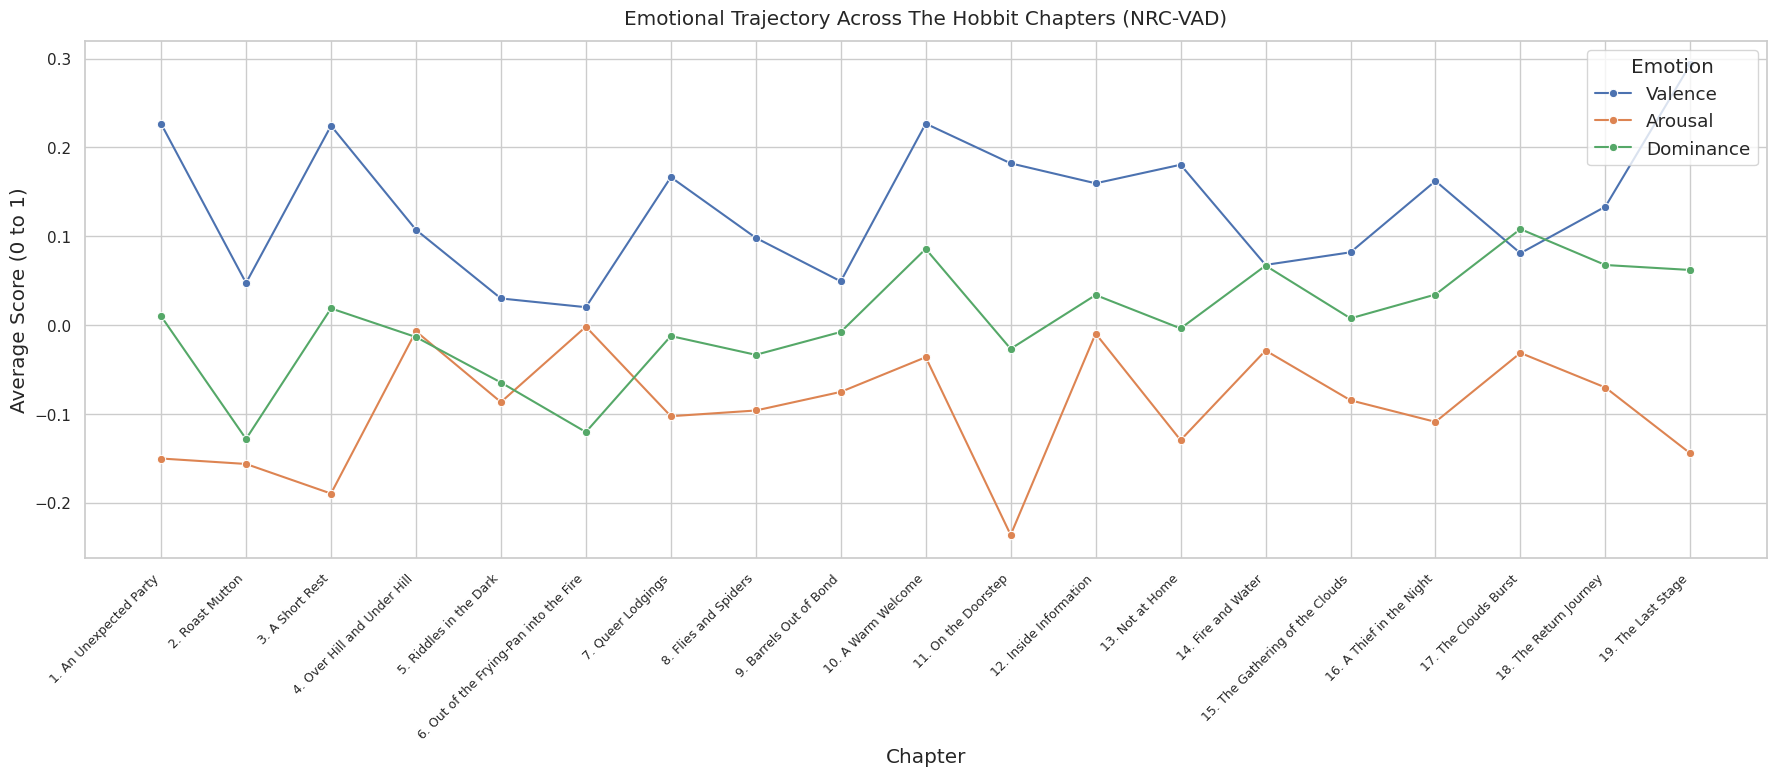

✅ Saved data: /content/drive/MyDrive/digphil/chapter_emotional_trajectory.csv


In [ ]:
# === Mount Google Drive ===
from google.colab import drive
try:
    drive.flush_and_unmount()
except Exception:
    pass
drive.mount('/content/drive', force_remount=True)

# === Project folder ===
import os
os.chdir('/content/drive/MyDrive/digphil')
print("✅ CWD:", os.getcwd())

# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, numpy as np

# --- Load VAD lexicon ---
lexicon_file_path = "NRC-VAD-Lexicon.txt"
vad_df = pd.read_csv(
    lexicon_file_path,
    sep="\t",
    names=["term", "valence", "arousal", "dominance"],
    header=0,
    dtype={"valence": float, "arousal": float, "dominance": float}
).set_index("term")

def compute_vad(text):
    if pd.isna(text):
        return {"valence": None, "arousal": None, "dominance": None}
    words = re.findall(r'\b\w+\b', str(text).lower())
    v, a, d = [], [], []
    for w in words:
        if w in vad_df.index:
            row = vad_df.loc[w]
            v.append(float(row["valence"]))
            a.append(float(row["arousal"]))
            d.append(float(row["dominance"]))
    if v:
        return {"valence": np.mean(v), "arousal": np.mean(a), "dominance": np.mean(d)}
    return {"valence": None, "arousal": None, "dominance": None}

# --- Aggregate chapter scores ---
dialogues_folder = "dialogues_filtered"
chapter_vad_scores = []
chapter_files = sorted([f for f in os.listdir(dialogues_folder)
                        if f.startswith("chapter_") and f.endswith("_dialogues.csv")])

for file_name in chapter_files:
    fp = os.path.join(dialogues_folder, file_name)
    m = re.search(r'chapter_(\d+)_dialogues\.csv', file_name)
    if not m:
        continue
    ch = int(m.group(1))
    df = pd.read_csv(fp, on_bad_lines='warn', encoding='utf-8')
    if 'dialogue' not in df.columns or df['dialogue'].empty:
        continue
    scores = df['dialogue'].apply(compute_vad)
    exp = pd.DataFrame(scores.tolist()).dropna()
    if not exp.empty:
        avg = exp[['valence','arousal','dominance']].mean().to_dict()
        avg['chapter'] = ch
        chapter_vad_scores.append(avg)

chapter_vad_df = pd.DataFrame(chapter_vad_scores).sort_values('chapter')

# --- Chapter titles (single line, like before) ---
chapter_titles = [
    "1. An Unexpected Party","2. Roast Mutton","3. A Short Rest",
    "4. Over Hill and Under Hill","5. Riddles in the Dark",
    "6. Out of the Frying-Pan into the Fire","7. Queer Lodgings",
    "8. Flies and Spiders","9. Barrels Out of Bond","10. A Warm Welcome",
    "11. On the Doorstep","12. Inside Information","13. Not at Home",
    "14. Fire and Water","15. The Gathering of the Clouds",
    "16. A Thief in the Night","17. The Clouds Burst",
    "18. The Return Journey","19. The Last Stage"
]
chapter_vad_df['chapter_title'] = chapter_titles[:len(chapter_vad_df)]

# --- Plot: figure with classic seaborn style and angled labels ---
sns.set(style="whitegrid", font_scale=1.2)  
plt.figure(figsize=(18, 8))                

for emotion, label in [("valence","Valence"),("arousal","Arousal"),("dominance","Dominance")]:
    chapter_vad_df[emotion] = pd.to_numeric(chapter_vad_df[emotion], errors='coerce')
    sns.lineplot(
        data=chapter_vad_df,
        x="chapter_title", y=emotion,
        label=label, marker="o"
    )

plt.title("Emotional Trajectory Across The Hobbit Chapters (NRC-VAD)", pad=12)
plt.xlabel("Chapter")
plt.ylabel("Average Score (0 to 1)")

plt.xticks(rotation=45, ha="right")
plt.tick_params(axis='x', labelsize=9)
plt.tick_params(axis='y', labelsize=11)

plt.legend(title="Emotion")
plt.tight_layout()

# save high-res and show
graph_path = "/content/drive/MyDrive/digphil/chapter_emotional_trajectory.png"
plt.savefig(graph_path, dpi=300, bbox_inches="tight")
print(f"📊 Saved figure: {graph_path}")
plt.show()

# also save the data (including titles)
out_csv = "/content/drive/MyDrive/digphil/chapter_emotional_trajectory.csv"
chapter_vad_df.to_csv(out_csv, index=False)
print(f"✅ Saved data: {out_csv}")
